# Face tracking by using CNNs

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fun
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import os
import cv2
import gc
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"= Using device {device}")
torch.cuda.is_available()

= Using device cuda


True

### 1. DATASET


DATASET from WIDER FACE: A Face Detection Benchmark

link: https://shuoyang1213.me/WIDERFACE/

    1. download WIDER Face Training Images (used for training)
    2. download WIDER Face Validation Images (used for testing since WIDER face test images are not annotated)
    3. download Face Annotations
            -- from this file extract wider_face_train_bbx_gt.txt and wider_face_val_bbx_gt.txt (these txt files contain bounding box of face for each image(left, top, width, height))
    

main directory should look like this:

<img src="directory.png"
     alt="cirectories"
     style="float: left; margin-right: 10px;" />

#### Data for bounding box

In [3]:
# function to create annotation for each image (path of image + bounding box of face)

def create_annotations(path, pres):
    images_info = []
    
    with open(path) as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        tmp = lines[i+1]

        if int(tmp)==1: #one person per image
            image_info = []

            image_path = pres + lines[i]    #image name
            bounds = lines[i+2].split(" ")
            x = int(bounds[0])  # x to left
            y = int(bounds[1])  # top
            width = int(bounds[2]) # width of face
            height = int(bounds[3]) # height of face

            image_info.extend([image_path.strip(), x, y, width, height])
            images_info.append(image_info)

            i = i + 3
        else:
            if int(tmp) == 0:
                i = i + 3
            else :   
                i = i + int(tmp) + 2
        
    return images_info

In [4]:
#train dataset annotation
path = "wider_face_train_bbx_gt.txt"
images_info_train = create_annotations(path, "WIDER_train/images/")

In [5]:
#test dataset annotation
path = "wider_face_val_bbx_gt.txt"
images_info_test = create_annotations(path, "WIDER_val/images/")

In [6]:
for i in range(1,12):
    images_info_train.pop(-i)

In [7]:
#number of images in train set
len(images_info_train)

4620

In [8]:
for i in range(1,3):
    images_info_test.pop(-i)

In [9]:
#number of images in test set
len(images_info_test)

1120

EXAMPLE IMAGE IN DATASET
IMAGE INFO: NAME, x, y, width, height : 
['WIDER_val/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_658.jpg', 247, 178, 364, 491]


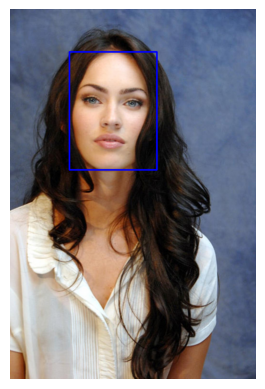

In [10]:
#example image from dataset
#display of image and bounding box around the face
print("EXAMPLE IMAGE IN DATASET")
print("IMAGE INFO: NAME, x, y, width, height : ")
pp = -16
print(images_info_test[pp])


path = images_info_test[pp][0]
img = cv2.imread(path)


image = cv2.rectangle(img, (int(images_info_test[pp][1]), int(images_info_test[pp][2])),(int(images_info_test[pp][3]) + 
                                                                               int(images_info_test[pp][1]),
                                              int(images_info_test[pp][4]) + int(images_info_test[pp][2])) , (255, 0, 0), 5)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### Images data

In [11]:
train_size = len(images_info_train)
test_size = len(images_info_test)
resize_size = 256

###### Train images dataset

In [27]:
#directory for test dataset
try:
    os.makedirs("train_dataset")
except FileExistsError:
    # directory already exists
    pass

In [12]:
#creating image train dataset

for i in range(0,train_size):

    image_info = images_info_train[i]
    image_path = image_info[0]
    
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    x = int(image_info[1])
    y = int(image_info[2])
    width = int(image_info[3])
    height = int(image_info[4])
    

    #rescaling images to 256x256 pixels, variable resize_size = 256
    original_height = img.shape[0]
    original_width = img.shape[1]
    
    
    images_info_train[i][1] = float(x/(original_width/resize_size))
    images_info_train[i][2] = float(y/(original_height/resize_size))
    images_info_train[i][3] = float(width/(original_width/resize_size))
    images_info_train[i][4] = float(height/(original_height/resize_size))
    
    #cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 5)

    img = cv2.resize(img, (resize_size, resize_size)) 
    
    #save image to folder train_dataset
    cv2.imwrite("train_dataset"+'\\'+image_path.split("/")[3], img)


In [29]:
f = open('cvs_train.cvs', 'w')

writer = csv.writer(f)

i = 0

while i < len(images_info_train):
    row = [images_info_train[i][1], images_info_train[i][2], images_info_train[i][3], images_info_train[i][4]]
    writer.writerow(row)
    i = i + 1

f.close()

##### Test images dataset

In [30]:
#directory for test dataset
try:
    os.makedirs("test_dataset")
except FileExistsError:
    # directory already exists
    pass

In [13]:
#creating image test dataset

for i in range(0,test_size):

    image_info = images_info_test[i]
    image_path = image_info[0]
    
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    x = int(image_info[1])
    y = int(image_info[2])
    width = int(image_info[3])
    height = int(image_info[4])
    

    #rescaling images to 256x256 pixels, variable resize_size = 256
    original_height = img.shape[0]
    original_width = img.shape[1]
    
    
    images_info_test[i][1] = float(x/(original_width/resize_size))
    images_info_test[i][2] = float(y/(original_height/resize_size))
    images_info_test[i][3] = float(width/(original_width/resize_size))
    images_info_test[i][4] = float(height/(original_height/resize_size))
    
    #cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 5)

    img = cv2.resize(img, (resize_size, resize_size)) 
    
    #save image to folder test_dataset
    cv2.imwrite("test_dataset"+'\\'+image_path.split("/")[3], img)


In [32]:
f = open('cvs_test.cvs', 'w')

writer = csv.writer(f)

i = 0

while i < len(images_info_test):
    row = [images_info_test[i][1], images_info_test[i][2], images_info_test[i][3], images_info_test[i][4]]
    writer.writerow(row)
    i = i + 1

f.close()

### MODELS

In [14]:
#starting
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=5,
            stride=2,
            padding=0
        )

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=0
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=1,
            padding=0
        )


        self.fc1 = nn.Linear(
            in_features=25*25*128,
            out_features=2046
        )

        self.fc2 = nn.Linear(
            in_features=2046,
            out_features=4
        )

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.relu(self.conv2(val))
        val = fun.max_pool2d(val, kernel_size=2, stride=2)
        val = fun.relu(self.conv3(val))
        val = val.view(-1, 25*25*128)
        val = fun.dropout(fun.relu(self.fc1(val)), p=0.5, training=self.training)
        val = self.fc2(val)

        return val

In [14]:
#AlexNet
class cnn_model(nn.Module):

    def __init__(self):
        
        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size=11,
            stride=4,
            padding=0
        )

        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=256,
            kernel_size=5,
            stride=1,
            padding=2
        )

        self.conv3 = nn.Conv2d(
            in_channels=256,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.conv4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.conv5 = nn.Conv2d(
            in_channels=384,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.fc1 = nn.Linear(
            in_features=6*6*256,
            out_features=4096
        )
        
        self.fc2 = nn.Linear(
            in_features=4096,
            out_features=1024
        )

        self.fc3 = nn.Linear(
            in_features=1024,
            out_features=4
        )

    def forward(self, val):
        val = fun.relu(self.conv1(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = fun.relu(self.conv2(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = fun.relu(self.conv3(val))
        val = fun.relu(self.conv4(val))
        val = fun.relu(self.conv5(val))
        val = fun.max_pool2d(val, kernel_size=3, stride=2)
        val = val.view(-1, 6*6*256)
        val = fun.dropout(fun.relu(self.fc1(val)), p=0.5, training=self.training)
        val = fun.dropout(fun.relu(self.fc2(val)), p=0.5, training=self.training)
        val = self.fc3(val)

        return val

In [15]:
model = cnn_model().to(device)

In [24]:
summary(model1, (3, 256, 256)) #starting
summary(model2, (3, 256, 256)) #AlexNet

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 126, 126]        2,432
├─Conv2d: 1-2                            [-1, 64, 59, 59]          51,264
├─Conv2d: 1-3                            [-1, 128, 25, 25]         204,928
├─Linear: 1-4                            [-1, 2046]                163,682,046
├─Linear: 1-5                            [-1, 4]                   8,188
Total params: 163,948,858
Trainable params: 163,948,858
Non-trainable params: 0
Total mult-adds (M): 508.02
Input size (MB): 0.75
Forward/backward pass size (MB): 6.20
Params size (MB): 625.42
Estimated Total Size (MB): 632.37
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 96, 62, 62]          34,944
├─Conv2d: 1-2                            [-1, 256, 30, 30]         614,656
├─Conv2d: 1-3                            [-1, 384, 14, 14]         885,120
├─Conv2d: 1-4            

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 96, 62, 62]          34,944
├─Conv2d: 1-2                            [-1, 256, 30, 30]         614,656
├─Conv2d: 1-3                            [-1, 384, 14, 14]         885,120
├─Conv2d: 1-4                            [-1, 384, 14, 14]         1,327,488
├─Conv2d: 1-5                            [-1, 256, 14, 14]         884,992
├─Linear: 1-6                            [-1, 4096]                37,752,832
├─Linear: 1-7                            [-1, 1024]                4,195,328
├─Linear: 1-8                            [-1, 4]                   4,100
Total params: 45,699,460
Trainable params: 45,699,460
Non-trainable params: 0
Total mult-adds (G): 1.34
Input size (MB): 0.75
Forward/backward pass size (MB): 6.14
Params size (MB): 174.33
Estimated Total Size (MB): 181.22

In [16]:
i = 0

test_images_l = []

while i < len(images_info_test):
    img = cv2.imread("./test_dataset/"+images_info_test[i][0].split("/")[3], cv2.IMREAD_COLOR) 
    arr = np.array(img)
    arr = arr.flatten()
    test_images_l.append(arr)
    i = i + 1

In [17]:
test_images_l[0].shape

(196608,)

In [18]:
i = 0

train_images_l = []

while i < len(images_info_train):
    img = cv2.imread("./train_dataset/"+images_info_train[i][0].split("/")[3], cv2.IMREAD_COLOR) 
    arr = np.array(img)
    arr = arr.ravel()
    train_images_l.append(arr.tolist())
    i = i + 1

In [40]:
def evaluate(net, criterion, size, device):
    net.eval()
    
    test_loss = 0
    rands = np.random.randint(test_size, size=size)
    for i in range(size):
        index = rands[i]
        img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
        inputs = torch.Tensor(np.array(img).ravel()).view(1, 3, 256, 256).to(device)

        outputs = torch.squeeze(net(inputs))
        labels = torch.Tensor(np.array(images_info_test[index][1:])).to(device)

        test_loss = test_loss + criterion(outputs, labels)

        del inputs, outputs, labels
            
    return test_loss.detach().cpu().item()/size

In [43]:
def train_model(net, train_loader, batchSize, epochs, lr_rate, momentum, device):
    prev_loss=0
    criterion = nn.MSELoss()
    optimization = optim.SGD(net.parameters(), lr=lr_rate, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimization, step_size=30, gamma=0.1)

    for epoch in range(epochs):
        net.train()
        
        loss_avg = 0
        
        for i, data in enumerate(train_loader):
            optimization.zero_grad()

            inputs, labels = data
            inputs, labels = inputs.view(batchSize, 3, 256, 256).to(device), labels.view(batchSize, 4).to(device)

            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimization.step()
            
            del inputs, outputs, labels
            
            loss_avg = loss_avg + loss.item()
        
        scheduler.step()
        print("epoch " + str(epoch+1) + ".  loss: " + str(loss_avg/batchSize))
        
        #ako CUDA memorija zapne, smanji size
        test_loss = evaluate(net, criterion, 50, device)
        
        print("     avg test loss for this epoch: " + str(test_loss))
        if abs(test_loss-prev_loss)<0:
            break
        prev_loss=test_loss
        
        if test_loss < 1000.00:
            torch.save(model.state_dict(), './model-' + str(epoch+1) + '.pth')
            break


In [29]:
class training_dataset(Dataset):
    
    def __init__(self):
        trainX = np.asarray(train_images_l)
        self.len = len(trainX)
        
        trainY = np.asarray(pd.read_csv('cvs_train.cvs', sep=',', header=None))
        
        self.features_train = torch.Tensor(trainX)
        self.groundTruth_train = torch.Tensor(trainY)

    def __getitem__(self, item):
        return self.features_train[item], self.groundTruth_train[item]

    def __len__(self):
        return self.len

In [30]:
ts = training_dataset()

In [48]:
learning_rate = 0.000001
momentum = 0.9
batch = 20
no_of_workers = 0
shuffle = True
epochs = 50

train_loader = DataLoader(
        dataset=ts,
        batch_size=batch,
        shuffle=shuffle,
        pin_memory=True,
        num_workers=no_of_workers)

In [ ]:
train_model(model, train_loader, batch, epochs, learning_rate, momentum, device)

epoch 1.  loss: 33048.20234375
     avg test loss for this epoch: 1124.38625
epoch 2.  loss: 21854.55728149414
     avg test loss for this epoch: 1412.77
epoch 3.  loss: 20788.15164489746
     avg test loss for this epoch: 1811.998125
epoch 4.  loss: 20811.839575195314
     avg test loss for this epoch: 1615.84765625
epoch 5.  loss: 20718.60317993164
     avg test loss for this epoch: 1518.6040625
epoch 6.  loss: 20642.113800048828
     avg test loss for this epoch: 1468.8346875
epoch 7.  loss: 20341.967736816405
     avg test loss for this epoch: 1570.4609375
epoch 8.  loss: 20384.759436035158
     avg test loss for this epoch: 1435.524375
epoch 9.  loss: 20309.064025878906
     avg test loss for this epoch: 1308.139765625
epoch 10.  loss: 20374.270254516603
     avg test loss for this epoch: 1425.32953125
epoch 11.  loss: 20372.62632751465
     avg test loss for this epoch: 1247.498515625
epoch 12.  loss: 20311.75174560547
     avg test loss for this epoch: 1655.3446875
epoch 13.  lo

In [82]:
torch.cuda.memory_allocated()

655830016

In [46]:
#run after every training to clear access memory
gc.collect()
torch.cuda.empty_cache()

In [56]:
## WIP

#from torchmetrics import Accuracy

def accuracy(net, criterion, size, device):
    acc=0
    rands = np.random.randint(test_size, size=size)
    for i in range(size):
        index = rands[i]
        img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
        inputs = torch.Tensor(np.array(img).ravel())
        inputs = inputs.view(1, 3, 256, 256)
        preds = torch.squeeze(model(inputs).detach().cpu())
    
        target = torch.Tensor(images_info_test[index][1:])
    
        accuracy = pass
        temp_acc = accuracy(preds, target).item()
        acc=acc+temp_acc
    
    print("Accuracy = " + str(acc*100/test_size) + "%")

tensor([104.0037,  51.0232,  45.3604,  62.2476])
tensor([104.5037,  51.5232,  45.8604,  62.7476])
0.0


In [49]:
torch.save(model.state_dict(), './model.pth')

###### example test for images in test dataset

In [50]:
def test_image(index):
    
    img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
    image_true = cv2.rectangle(img, (int(images_info_test[index][1]), int(images_info_test[index][2])),(int(images_info_test[index][3]) + 
                                                                               int(images_info_test[index][1]),
                                              int(images_info_test[index][4]) + int(images_info_test[index][2])) , (255, 0, 0), 1)
    #image_true = cv2.resize(image, (600, 800))
    
    inputs = torch.Tensor(np.array(img).ravel())
    inputs = inputs.view(1, 3, 256, 256)
    predict = torch.squeeze(model(inputs.to(device)).detach().cpu()).tolist()
    
    print("true value of bounding box:")
    print(images_info_test[index][1:])
    print()
    print("predicted value of bounding box:")
    print(predict)
    
    img = cv2.imread("./test_dataset/"+images_info_test[index][0].split("/")[3], cv2.IMREAD_COLOR) 
    image_pred = cv2.rectangle(img, (int(predict[0]), int(predict[1])),(int(predict[2]) + 
                                                                               int(predict[0]),
                                              int(predict[3]) + int(predict[1])) , (255, 0, 0), 1)
    #image_pred = cv2.resize(image_pred, (600, 800))
    
    plt.subplot(1, 2, 1)

    plt.imshow(cv2.cvtColor(image_true, cv2.COLOR_BGR2RGB))
    plt.title("true")
    plt.axis('off')
    plt.show()

    plt.subplot(1, 2, 2)

    plt.imshow(cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB))
    plt.title("predicted")
    plt.axis('off')
    plt.show()

0. Image

true value of bounding box:
[125.25, 30.007326007326007, 71.25, 83.08278388278389]

predicted value of bounding box:
[118.3702392578125, 50.34629821777344, 49.16559982299805, 52.840484619140625]


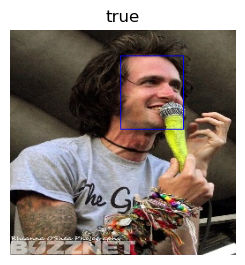

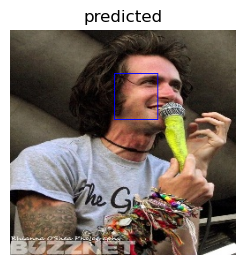

2. Image

true value of bounding box:
[160.75, 56.0, 81.0, 92.16666666666667]

predicted value of bounding box:
[107.70339965820312, 39.98178482055664, 74.32283782958984, 76.33642578125]


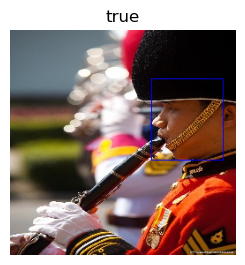

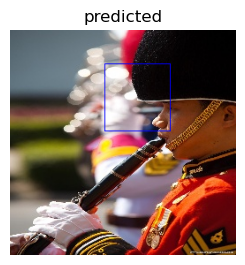

4. Image

true value of bounding box:
[78.5, 86.96123076923077, 28.5, 13.548307692307691]

predicted value of bounding box:
[138.01162719726562, 50.866722106933594, 10.901671409606934, 17.061059951782227]


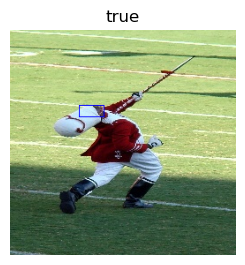

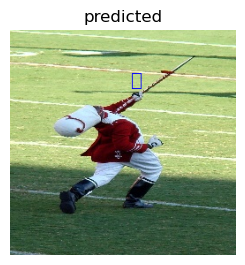

In [51]:
#test for images in test dataset
pics = [0, 2, 4]
model.load_state_dict(torch.load('./model.pth'))
model.eval()

for i in pics:
    print(str(i) + ". Image")
    print()
    test_image(i)